<a href="https://colab.research.google.com/github/fernandofsilva/desafio-alelo/blob/main/notebooks/RF_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classifier

## Setup

In [ ]:
# Data handling
import pandas as pd

# Modules for feature engineering and modelling
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Plot
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load data and merge

In [ ]:
# Characters powers
powers = pd.read_csv("drive/MyDrive/Datasets/super_hero_powers.csv")

# Characters information
info = pd.read_csv(
    "drive/MyDrive/Datasets/heroes_information.csv",
    index_col=0, 
    na_values=['-', -99.0]
)

# Merge databases
data = info.merge(right=powers, how='inner', left_on='name', right_on='hero_names')
data.drop('hero_names', axis=1, inplace=True)

# Removed characters without aligment or neutral value
data = data[data['Alignment'].isin(['bad', 'good'])]

## Feature Engineering

### Class for variable selection

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

### Define columns according to each

In [ ]:
# Categorical columns name
categorical = list(info.select_dtypes('object').columns)[1:-1]

# Numeric columns name
numerical = list(info.select_dtypes('number').columns)

# Boolean columns name
boolean = list(powers.select_dtypes('bool').columns)

### Construct feature engineering graph

In [ ]:
# Define categorical pipeline
cat_pipe = Pipeline(
    [('selector', ColumnSelector(categorical)),
     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline(
    [('selector', ColumnSelector(numerical)),
     ('imputer', SimpleImputer(strategy='median')),
     ('scaler', StandardScaler())])

# Define boolean pipeline
bool_pipe = Pipeline(
    [('selector', ColumnSelector(boolean)),
     ('pca', PCA(n_components=0.95))])

# Fit column transformer to training data
preprocessor = FeatureUnion(
    [('categorical', cat_pipe),
     ('numerical', num_pipe),
     ('boolean', bool_pipe)])

### Transform the target

Unfornately, Sklearn pipeline doen't have support to add a transformation in the target variable like the ReshapeEndpoint in Tensorflow.

In [ ]:
# Format the target variable
y = data['Alignment']
y.replace({'bad': 0, 'good': 1}, inplace=True)

## Model

In [ ]:
# Combine categorical and numerical pipeline with the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(min_samples_leaf=2))
])

### Fit and predict

The function cross_val_predict already has stratify the target variable, in other words, the function balance the target variable between the Kfolds.

In [ ]:
model.fit(data, y)
y_pred = cross_val_predict(model, data, y, cv=10)

## Metrics

Confusion Matrix RF Classifier
[[0.96907216 0.03092784]
 [0.         1.        ]]


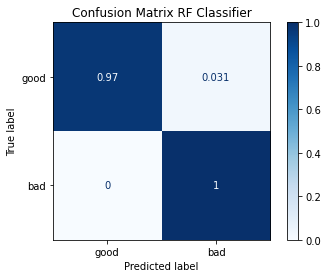

In [ ]:
# Plot confusition matrix with the results
title = 'Confusion Matrix RF Classifier'

disp = plot_confusion_matrix(
    model,
    data,
    y,
    display_labels=['good', 'bad'],
    cmap=plt.cm.Blues,
    normalize='true'
)

disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)